In [1]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import altair as alt
import seaborn as sns
import re
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
#Make sure numpy version is < 1.20
np.version.version

'1.18.5'

In [4]:
#Install known version of numpy that works
!python -m pip install numpy==1.18.5

     |████████████████████████████████| 15.1 MB 86 kB/s  eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow 2.6.0 requires numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
pmdarima 1.8.2 requires numpy~=1.19.0, but you'll have numpy 1.18.5 which is incompatible.


In [5]:
#Install gensim
!python -m pip install gensim

In [6]:
import gensim
from gensim.models.word2vec import Word2Vec
from tqdm.notebook import tqdm
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhouwei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/zhouwei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/zhouwei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
RANDOM_SEED=694

Training Dataset

In [8]:
train_path = 'Data/WikiLarge_Train.csv'
df = pd.read_csv(train_path, skiprows=0, skipfooter=0, engine='python')
df.head()

,original_text,label
0,There is manuscript evidence that Austen conti...,1
1,"In a remarkable comparative analysis , Mandaea...",1
2,"Before Persephone was released to Hermes , who...",1
3,Cogeneration plants are commonly found in dist...,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1


In [8]:
len(df[df['label']==1])/len(df) # the dataset label is well balanced 

0.5

In [9]:
df.iloc[410006]['original_text']

'Coastal lagoons , marshes , and deltas'

In [10]:
df.iloc[410000]['label']

0

In [11]:
df[df['label']==0]['original_text'].apply(lambda x: len(x)).mean()

98.05651105651106

In [12]:
df[df['label']==0]['original_text'].apply(lambda x: len(x)).std()

62.48601060526121

In [13]:
df[df['label']==0]['original_text'].apply(lambda x: len(x)).max()

589

In [14]:
df[df['label']==0]['original_text'].apply(lambda x: len(x)).min()

1

In [15]:
df[df['label']==1]['original_text'].apply(lambda x: len(x)).mean()

137.49607935350122

In [16]:
df[df['label']==1]['original_text'].apply(lambda x: len(x)).std()

71.79329759281585

In [17]:
df[df['label']==1]['original_text'].apply(lambda x: len(x)).max()

575

In [18]:
df[df['label']==1]['original_text'].apply(lambda x: len(x)).min()

1

In [19]:
df['text_length'] = df['original_text'].apply(len)

In [20]:
df[(df['label']==1) & (df['text_length']==50)].loc[27]['original_text']

'He has subsequently written a further nine plays .'

In [21]:
df[(df['label']==0) & (df['text_length']==5)]

,original_text,label,text_length
208709,Pages,0,5
208988,Plain,0,5
209004,Drama,0,5
209374,Child,0,5
209606,equal,0,5
209612,Super,0,5
209711,Kanye,0,5
209793,Stock,0,5
209797,Mashi,0,5
209945,Ariel,0,5


In [9]:
df.head()

,original_text,label
0,There is manuscript evidence that Austen conti...,1
1,"In a remarkable comparative analysis , Mandaea...",1
2,"Before Persephone was released to Hermes , who...",1
3,Cogeneration plants are commonly found in dist...,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1


In [23]:
df['original_text'].apply(lambda x: len(x)).mean()
# This means all texts are considered short text, which allows us to use dense representations, 
# as dense representations work well with short text.
# Gensim.KeyedVectors.load('assets/wikipedia.100.word-vecs.kv')??? How to generate and use this???
# Maybe we should train word2vec model on the entire corpus. Just training data? TOP 100 word-vectors(features)
# Alternatively we could use bag-of-words model, which is term-document matrix representation, having much more features

117.77629520500614

In [15]:
X = df['original_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Testing Dataset

In [16]:
test_path = 'Data/WikiLarge_Test.csv'
test_df = pd.read_csv(test_path, skiprows=0, skipfooter=0, engine='python')
test_df.head()

,id,original_text,label
0,0,-2011,NaN
1,1,-2011,NaN
2,2,-2000,NaN
3,3,-1997,NaN
4,4,1.636,NaN


In [17]:
test_df.iloc[10000]

id                                                           10000
original_text    An atheist would say that this argument proves...
label                                                          NaN
Name: 10000, dtype: object

Sample Submission

In [18]:
samplesubmission_path = 'Data/sampleSubmission.csv'
samplesubmission_df = pd.read_csv(samplesubmission_path, skiprows=0, skipfooter=0, engine='python')
samplesubmission_df.head()

,id,label
0,0,0
1,1,0
2,2,1
3,3,1
4,4,0


To conclude, the dataframes we are working with are:

dalechall_df, concreteness_df, aoawords_df, train_df, test_df, samplesubmission_df

# 1. Data Preprocessing

In [19]:
vectorizer = TfidfVectorizer(min_df=10,stop_words='english',ngram_range=(1,2))
X_train_transform = vectorizer.fit_transform(X_train)
X_test_transform  = vectorizer.transform(X_test)

In [20]:
X_train_transform

<333414x57516 sparse matrix of type '<class 'numpy.float64'>'
	with 4053454 stored elements in Compressed Sparse Row format>

## Word2Vec Model

In [21]:
len(stopwords.words('english'))

179

In [22]:
len(set(stopwords.words('english')))

179

In [23]:
#set(stopwords.words('english'))

== dale_chall.txt ==

This is the Dale Chall 3000 Word List, which is one definition of words that are considered "basic" English.

A summary is at https://www.readabilityformulas.com/articles/dale-chall-readability-word-list.php

In [24]:
#Basic english words
dalechall_path = 'Data/dale_chall.txt'
dale_chall = pd.read_csv(dalechall_path,delimiter='\t',header=None,names=['word'])
dale = set(dale_chall['word'].values)

In [25]:
len(dale)

2946

### The 2946 words in dale can be combined with the nltk stopwords.
### We could maybe assign an arbitrary score to each dale_chall word. - for reference only

### We will use a geo dataset to add city and country names to the stopwords library

In [26]:
!python -m pip install datapackage

     |████████████████████████████████| 85 kB 4.0 MB/s eta 0:00:011
     |████████████████████████████████| 72 kB 2.3 MB/s  eta 0:00:01
     |████████████████████████████████| 68 kB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 18.7 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 5.3 MB/s  eta 0:00:01
     |████████████████████████████████| 41 kB 4.8 MB/s  eta 0:00:01
     |████████████████████████████████| 79 kB 11.3 MB/s eta 0:00:01
     |████████████████████████████████| 8.8 MB 19.7 MB/s eta 0:00:01
  Created wheel for linear-tsv: filename=linear_tsv-1.1.0-py3-none-any.whl size=7381 sha256=3292657405a4fec561535bcd976e0538670ef97bdbe57fd806f714bb965fe81a
  Stored in directory: /Users/zhouwei/Library/Caches/pip/wheels/31/25/a5/d9b4b59636e1b9f183b7e1022e7be5c51141717b92398d7f9e
Successfully built linear-tsv


In [27]:
from datapackage import Package
package = Package('https://datahub.io/core/world-cities/datapackage.json')
# print list of all resources:
print(package.resource_names)

['validation_report', 'world-cities_csv', 'world-cities_json', 'world-cities_zip', 'world-cities_csv_preview', 'world-cities']


In [37]:
world_cities = []
for resource in package.resources:
    if resource.descriptor['datahub']['type'] == 'derived/csv':
        world_cities = resource.read()

In [38]:
len(world_cities)

23018

In [39]:
world_cities[:10]

[['les Escaldes', 'Andorra', 'Escaldes-Engordany', 3040051],
 ['Andorra la Vella', 'Andorra', 'Andorra la Vella', 3041563],
 ['Umm al Qaywayn', 'United Arab Emirates', 'Umm al Qaywayn', 290594],
 ['Ras al-Khaimah', 'United Arab Emirates', 'Raʼs al Khaymah', 291074],
 ['Khawr Fakkān', 'United Arab Emirates', 'Ash Shāriqah', 291696],
 ['Dubai', 'United Arab Emirates', 'Dubai', 292223],
 ['Dibba Al-Fujairah', 'United Arab Emirates', 'Al Fujayrah', 292231],
 ['Dibba Al-Hisn', 'United Arab Emirates', 'Al Fujayrah', 292239],
 ['Sharjah', 'United Arab Emirates', 'Ash Shāriqah', 292672],
 ['Ar Ruways', 'United Arab Emirates', 'Abu Dhabi', 292688]]

In [40]:
world_cities_df = pd.DataFrame(world_cities, columns=['name', 'country', 'subcountry', 'geonameid'])

In [41]:
world_cities_df

,name,country,subcountry,geonameid
0,les Escaldes,Andorra,Escaldes-Engordany,3040051
1,Andorra la Vella,Andorra,Andorra la Vella,3041563
2,Umm al Qaywayn,United Arab Emirates,Umm al Qaywayn,290594
3,Ras al-Khaimah,United Arab Emirates,Raʼs al Khaymah,291074
4,Khawr Fakkān,United Arab Emirates,Ash Shāriqah,291696
5,Dubai,United Arab Emirates,Dubai,292223
6,Dibba Al-Fujairah,United Arab Emirates,Al Fujayrah,292231
7,Dibba Al-Hisn,United Arab Emirates,Al Fujayrah,292239
8,Sharjah,United Arab Emirates,Ash Shāriqah,292672
9,Ar Ruways,United Arab Emirates,Abu Dhabi,292688


In [42]:
world_cities_df = world_cities_df.applymap(lambda s:s.lower() if type(s) == str else s)

In [43]:
world_cities_df[world_cities_df['country']=='france']

,name,country,subcountry,geonameid
6633,yerres,france,île-de-france,2967245
6634,wittenheim,france,alsace-champagne-ardenne-lorraine,2967318
6635,wattrelos,france,nord-pas-de-calais-picardie,2967421
6636,wasquehal,france,nord-pas-de-calais-picardie,2967438
6637,voiron,france,auvergne-rhône-alpes,2967758
6638,vitry-sur-seine,france,île-de-france,2967849
6639,vitry-le-françois,france,alsace-champagne-ardenne-lorraine,2967856
6640,vitrolles,france,provence-alpes-côte d'azur,2967870
6641,vitré,france,brittany,2967879
6642,viry-châtillon,france,île-de-france,2967917


In [44]:
cities = set(world_cities_df['name'].unique())
countries = set(world_cities_df['country'].unique())
subcountries = set(world_cities_df['subcountry'].unique())

In [45]:
#We will add this to stopwords
geo_data = cities | countries | subcountries

In [46]:
len(cities)

21940

In [47]:
len(countries)

244

In [48]:
len(subcountries)

2594

In [49]:
len(geo_data)

23803

In [50]:
language_package = Package('https://datahub.io/core/language-codes/datapackage.json')

# print list of all resources:
print(language_package.resource_names)

['validation_report', 'language-codes_csv', 'language-codes-3b2_csv', 'language-codes-full_csv', 'ietf-language-tags_csv', 'language-codes_json', 'language-codes-3b2_json', 'language-codes-full_json', 'ietf-language-tags_json', 'language-codes_zip', 'language-codes', 'language-codes-3b2', 'language-codes-full', 'ietf-language-tags']


In [51]:
# print processed tabular data (if exists any)
languages_data = []
#for resource in language_package.resources:
#    if resource.descriptor['datahub']['derivedFrom']=='language-codes':
#        print(resource.read())

In [52]:
languages_data = language_package.resources[1].read()

In [53]:
languages_df = pd.DataFrame(languages_data, columns=['alpha2', 'english'])
languages_df = languages_df.applymap(lambda s:s.lower() if type(s) == str else s)
languages_df

,alpha2,english
0,aa,afar
1,ab,abkhazian
2,ae,avestan
3,af,afrikaans
4,ak,akan
5,am,amharic
6,an,aragonese
7,ar,arabic
8,as,assamese
9,av,avaric


In [54]:
languages = set(languages_df['english'].unique())

In [55]:
len(languages)

184

In [56]:
nationality_path = 'Data/CH_Nationality_List_20171130_v1.csv'
nationality_df = pd.read_csv(nationality_path, skiprows=0, skipfooter=0, engine='python')
nationality_df = nationality_df.applymap(lambda s:s.lower() if type(s) == str else s)
nationality_df

,Nationality
0,afghan
1,albanian
2,algerian
3,american
4,andorran
5,angolan
6,anguillan
7,argentine
8,armenian
9,australian


In [123]:
nationalities = set(nationality_df['Nationality'].unique())
len(nationalities)

225

In [124]:
states_path = 'Data/states.csv'
states_df = pd.read_csv(states_path, skiprows=0, skipfooter=0, engine='python')
states_df = states_df.applymap(lambda s:s.lower() if type(s) == str else s)
states_df

,id,name,country_id,country_code,country_name,state_code,type,latitude,longitude
0,3901,badakhshan,1,af,afghanistan,bds,NaN,36.734772,70.811995
1,3871,badghis,1,af,afghanistan,bdg,NaN,35.167134,63.769538
2,3875,baghlan,1,af,afghanistan,bgl,NaN,36.178903,68.745306
3,3884,balkh,1,af,afghanistan,bal,NaN,36.755060,66.897537
4,3872,bamyan,1,af,afghanistan,bam,NaN,34.810007,67.821210
5,3892,daykundi,1,af,afghanistan,day,NaN,33.669495,66.046353
6,3899,farah,1,af,afghanistan,fra,NaN,32.495328,62.262663
7,3889,faryab,1,af,afghanistan,fyb,NaN,36.079561,64.905955
8,3870,ghazni,1,af,afghanistan,gha,NaN,33.545059,68.417397
9,3888,ghōr,1,af,afghanistan,gho,NaN,34.099578,64.905955


In [125]:
states = set(states_df['name'].unique())
len(states)

4896

In [126]:
continents_path = 'Data/continents2.csv'
continents_df = pd.read_csv(continents_path, skiprows=0, skipfooter=0, engine='python')
continents_df = continents_df.applymap(lambda s:s.lower() if type(s) == str else s)
continents_df

,,,,,,,,,,name
Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN
Andorra,AD,AND,20,ISO 3166-2:AD,Europe,Southern Europe,NaN,150.0,39.0,NaN
Angola,AO,AGO,24,ISO 3166-2:AO,Africa,Sub-Saharan Africa,Middle Africa,2.0,202.0,17.0
Anguilla,AI,AIA,660,ISO 3166-2:AI,Americas,Latin America and the Caribbean,Caribbean,19.0,419.0,29.0
Antarctica,AQ,ATA,10,ISO 3166-2:AQ,NaN,NaN,NaN,NaN,NaN,NaN
Antigua and Barbuda,AG,ATG,28,ISO 3166-2:AG,Americas,Latin America and the Caribbean,Caribbean,19.0,419.0,29.0


In [127]:
continents = set(continents_df['region'].unique())
len(continents)

KeyError: 'region'

In [128]:
firstname_path = 'Data/new-top-firstNames.csv'
firstname_df = pd.read_csv(firstname_path, skiprows=0, skipfooter=0, engine='python')
firstname_df = firstname_df.applymap(lambda s:s.lower() if type(s) == str else s)
firstname_df

,Unnamed: 0,name,newPerct2013
0,1,michael,0.011577
1,2,james,0.010218
2,3,john,0.009675
3,4,robert,0.009493
4,5,david,0.008943
5,6,william,0.007484
6,7,mary,0.006839
7,8,christopher,0.005901
8,9,joseph,0.005410
9,10,richard,0.005346


In [129]:
firstnames = set(firstname_df['name'].unique())
len(firstnames)

100

In [130]:
firstname_path2 = 'Data/babynames-clean.csv'
firstname_df2 = pd.read_csv(firstname_path2, header= None, skiprows=0, skipfooter=0, engine='python')
firstname_df2 = firstname_df2.applymap(lambda s:s.lower() if type(s) == str else s)
firstname_df2

,0,1
0,john,boy
1,william,boy
2,james,boy
3,charles,boy
4,george,boy
5,frank,boy
6,joseph,boy
7,thomas,boy
8,henry,boy
9,robert,boy


In [131]:
firstnames2 = set(firstname_df2[0].unique())
len(firstnames2)

6782

In [132]:
firstnames = firstnames | firstnames2
len(firstnames)

6782

In [133]:
surname_path = 'Data/new-top-surnames.csv'
surname_df = pd.read_csv(surname_path, skiprows=0, skipfooter=0, engine='python')
surname_df = surname_df.applymap(lambda s:s.lower() if type(s) == str else s)
surname_df

,Unnamed: 0,name,perct2013
0,1,smith,0.007999
1,2,johnson,0.006346
2,3,williams,0.005330
3,4,brown,0.004724
4,5,jones,0.004676
5,6,garcia,0.004063
6,7,rodriguez,0.003818
7,8,miller,0.003731
8,9,martinez,0.003669
9,10,davis,0.003649


In [134]:
surnames = set(surname_df['name'].unique())
len(surnames)

100

In [135]:
days=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
months=['January','February','March', 'April','May','June','July','August','September','October','November','December']
calendar = days.copy()
calendar.extend(months)
calendar = set([w.lower() for w in calendar])

In [136]:
calendar

{'april',
 'august',
 'december',
 'february',
 'friday',
 'january',
 'july',
 'june',
 'march',
 'may',
 'monday',
 'november',
 'october',
 'saturday',
 'september',
 'sunday',
 'thursday',
 'tuesday',
 'wednesday'}

In [28]:
X_train

304501    1979-80 Buffalo Sabres NHL 32 1880 74 1 4 2.36...
162313    Diseases Lentils in culture Lentils are mentio...
336845    Railroads , like the Lehigh Valley Railroad , ...
150625    An example of this would be an individual anim...
40240     Both the Matanuska and Susitna Rivers have maj...
                                ...                        
259178    After the Germans invaded Norway in April 1940...
365838    July 28 - Henry Bennet , 1st Earl of Arlington...
131932    Pancake restaurants are popular family restaur...
146867                                 A cycling domestique
121958    David Boreanaz 's first paid acting appearance...
Name: original_text, Length: 333414, dtype: object

In [29]:
X_train[304501]

'1979-80 Buffalo Sabres NHL 32 1880 74 1 4 2.36 20 8 4 0 0.000'

In [30]:
gensim.utils.simple_preprocess(X_train[304501])

['buffalo', 'sabres', 'nhl']

In [31]:
#gensim.parsing.preprocessing.STOPWORDS
#stopWords

In [32]:
tokenized_text_train=[]
tokenized_text_test=[]
stopWords = set(stopwords.words('english')) | dale# | geo_data | languages | nationalities | states | continents | firstnames | surnames | calendar
# This cell will run 4 minutes
import gensim
from nltk.stem.porter import *
def lemmatize_stemming(text):
    stemmer = PorterStemmer()
    #Un-hash next line to use stemming
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
    #Un-hash next line to NOT use stemming
    #return WordNetLemmatizer().lemmatize(text, pos='v')

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in stopWords and len(token) > 3:
            #Un-hash next line to use lemmatization/stemming
            result.append(lemmatize_stemming(token))
            #Un-hash next line to NOT use lemmatization/stemming
            #result.append(token)
            
    return result

tokenized_text_train = [preprocess(text) for text in X_train]
tokenized_text_test=[preprocess(text) for text in X_test]

#for text in tqdm(X_train):
#    tokens_in_text = word_tokenize(text)
#    tokens_in_text = [word for word in tokens_in_text if word.lower() not in stopWords]
#    tokenized_text_train.append(tokens_in_text)
    
#for text in tqdm(X_test):
#    tokens_in_text = word_tokenize(text)
#    tokens_in_text = [word for word in tokens_in_text if word.lower() not in stopWords]
#    tokenized_text_test.append(tokens_in_text)

In [33]:
len(stopWords)

2986

In [34]:
#tokenized_text_train

In [35]:
model = Word2Vec(vector_size=100,window=2,min_count=100,seed= RANDOM_SEED,workers=4)
model.build_vocab(tokenized_text_train)
model.train(tokenized_text_train,total_examples=model.corpus_count,epochs=model.epochs)

(8111671, 11761790)

In [36]:
word_vectors = model.wv

In [37]:
#word_vectors.vocab

In [38]:
word_dict = word_vectors.key_to_index

In [39]:
word_dict

{'franc': 0,
 'unit': 1,
 'commun': 2,
 'depart': 3,
 'region': 4,
 'state': 5,
 'american': 6,
 'includ': 7,
 'call': 8,
 'nation': 9,
 'play': 10,
 'area': 11,
 'locat': 12,
 'univers': 13,
 'district': 14,
 'releas': 15,
 'year': 16,
 'refer': 17,
 'name': 18,
 'english': 19,
 'album': 20,
 'system': 21,
 'seri': 22,
 'former': 23,
 'origin': 24,
 'later': 25,
 'german': 26,
 'septemb': 27,
 'british': 28,
 'januari': 29,
 'calai': 30,
 'current': 31,
 'juli': 32,
 'octob': 33,
 'august': 34,
 'centuri': 35,
 'popul': 36,
 'leagu': 37,
 'june': 38,
 'decemb': 39,
 'provinc': 40,
 'april': 41,
 'novemb': 42,
 'england': 43,
 'produc': 44,
 'work': 45,
 'februari': 46,
 'develop': 47,
 'base': 48,
 'award': 49,
 'intern': 50,
 'london': 51,
 'french': 52,
 'presid': 53,
 'john': 54,
 'largest': 55,
 'record': 56,
 'start': 57,
 'form': 58,
 'ndash': 59,
 'creat': 60,
 'main': 61,
 'usual': 62,
 'central': 63,
 'offici': 64,
 'germani': 65,
 'municip': 66,
 'japanes': 67,
 'forc': 68,


In [40]:
word_vectors[0] == word_vectors['unite']

KeyError: "Key 'unite' not present"

In [ ]:
words_in_vector = word_vectors.index_to_key
len(words_in_vector)

# Word's Difficulty Considered

== Concreteness_ratings_Brysbaert_et_al_BRM.txt ==

This file contains concreteness ratings for 40 thousand English lemma words gathered via Amazon Mechanical Turk. The ratings come from a larger list of 63 thousand words and represent all English words known to 85% of the raters.

The file contains eight columns:
1. The word
2. Whether it is a single word or a two-word expression 
3. The mean concreteness rating
4. The standard deviation of the concreteness ratings
5. The number of persons indicating they did not know the word
6. The total number of persons who rated the word
7. Percentage participants who knew the word
8. The SUBTLEX-US frequency count (on a total of 51 million; Brysbaert & New, 2009) 
9. The dominant part-of-speech usage

Original source: http://crr.ugent.be/archives/1330

Brysbaert, M., Warriner, A.B., & Kuperman, V. (2014). Concreteness ratings for 40 thousand generally known English word lemmas. Behavior Research Methods, 46, 904-911.
http://crr.ugent.be/papers/Brysbaert_Warriner_Kuperman_BRM_Concreteness_ratings.pdf

In [151]:
#Concreteness rating - the higher Conc.M, the easier the word is.
concreteness_path = 'Data/Concreteness_ratings_Brysbaert_et_al_BRM.txt'
concrete_df = pd.read_csv(concreteness_path,delimiter='\t', keep_default_na=False)
concreteset=(concrete_df['Word'].values)

In [152]:
concrete_df

,Word,Bigram,Conc.M,Conc.SD,Unknown,Total,Percent_known,SUBTLEX,Dom_Pos
0,roadsweeper,0,4.85,0.37,1,27,0.96,0,0
1,traindriver,0,4.54,0.71,3,29,0.90,0,0
2,tush,0,4.45,1.01,3,25,0.88,66,0
3,hairdress,0,3.93,1.28,0,29,1.00,1,0
4,pharmaceutics,0,3.77,1.41,4,26,0.85,0,0
5,hoover,0,3.76,1.23,4,29,0.86,162,0
6,shopkeeping,0,3.18,1.19,1,29,0.97,0,0
7,pushiness,0,2.48,1.24,1,30,0.97,0,0
8,underdevelop,0,2.37,1.40,0,30,1.00,0,0
9,tirelessness,0,2.28,1.28,1,30,0.97,0,0


In [153]:
concrete_df['stem'] = concrete_df['Word'].apply(lemmatize_stemming)

In [154]:
concrete_df

,Word,Bigram,Conc.M,Conc.SD,Unknown,Total,Percent_known,SUBTLEX,Dom_Pos,stem
0,roadsweeper,0,4.85,0.37,1,27,0.96,0,0,roadsweep
1,traindriver,0,4.54,0.71,3,29,0.90,0,0,traindriv
2,tush,0,4.45,1.01,3,25,0.88,66,0,tush
3,hairdress,0,3.93,1.28,0,29,1.00,1,0,hairdress
4,pharmaceutics,0,3.77,1.41,4,26,0.85,0,0,pharmaceut
5,hoover,0,3.76,1.23,4,29,0.86,162,0,hoover
6,shopkeeping,0,3.18,1.19,1,29,0.97,0,0,shopkeep
7,pushiness,0,2.48,1.24,1,30,0.97,0,0,pushi
8,underdevelop,0,2.37,1.40,0,30,1.00,0,0,underdevelop
9,tirelessness,0,2.28,1.28,1,30,0.97,0,0,tireless


In [155]:
concrete_df.Bigram.value_counts()

0    37058
1     2896
Name: Bigram, dtype: int64

In [156]:
concrete_df[concrete_df.Bigram==1]

,Word,Bigram,Conc.M,Conc.SD,Unknown,Total,Percent_known,SUBTLEX,Dom_Pos,stem
28707,baking soda,1,5.00,0.00,0,30,1.00,0,#N/A,baking soda
28709,baseball bat,1,5.00,0.00,0,29,1.00,0,#N/A,baseball bat
28710,bath towel,1,5.00,0.00,0,29,1.00,0,#N/A,bath towel
28711,beach ball,1,5.00,0.00,0,28,1.00,0,#N/A,beach bal
28712,bed sheet,1,5.00,0.00,0,28,1.00,0,#N/A,bed sheet
28714,big toe,1,5.00,0.00,1,29,0.97,0,#N/A,big to
28715,birth certificate,1,5.00,0.00,0,27,1.00,0,#N/A,birth certif
28716,bomb shelter,1,5.00,0.00,0,28,1.00,0,#N/A,bomb shelt
28717,bowling ball,1,5.00,0.00,0,30,1.00,0,#N/A,bowling bal
28718,brussels sprouts,1,5.00,0.00,0,28,1.00,0,#N/A,brussels sprout


In [157]:
#There is no Nan value in Conc.M column
concrete_df[concrete_df['Conc.M'].isna()]

,Word,Bigram,Conc.M,Conc.SD,Unknown,Total,Percent_known,SUBTLEX,Dom_Pos,stem


### Are we gonna consider bigrams in this dataset, given it's only a small fraction ~ 8% in size?

In [158]:
np.min(concrete_df['Conc.M'])

1.04

In [159]:
np.max(concrete_df['Conc.M'])

5.0

### Concreteness values range from 1 - 5, we could possible use the inverse value of concreteness to scale it to a 0-1 range and give easier words less weight.

In [160]:
concrete_words = list(concrete_df['Word'].values)

In [161]:
concrete_words = list(concrete_df['stem'].values)

In [162]:
len(concrete_words)

39954

In [163]:
concrete_complement = [word for word in words_in_vector if word not in concrete_words]

In [164]:
len(concrete_complement)

867

In [165]:
concrete_complement

['franc',
 'english',
 'german',
 'british',
 'calai',
 'england',
 'london',
 'french',
 'largest',
 'ndash',
 'germani',
 'japanes',
 'york',
 'america',
 'australia',
 'nord',
 'italian',
 'william',
 'aisn',
 'europ',
 'picardi',
 'pakistan',
 'greek',
 'european',
 'georg',
 'spanish',
 'normandi',
 'india',
 'calvado',
 'california',
 'switzerland',
 'canton',
 'canada',
 'charl',
 'australian',
 'itali',
 'henri',
 'loir',
 'canadian',
 'girond',
 'scotland',
 'mari',
 'robert',
 'ireland',
 'africa',
 'paul',
 'latin',
 'florida',
 'brazilian',
 'aquitain',
 'russian',
 'david',
 'indian',
 'chines',
 'michael',
 'asia',
 'pari',
 'richard',
 'berlin',
 'scottish',
 'dutch',
 'spain',
 'iowa',
 'disney',
 'thoma',
 'wale',
 'edward',
 'britain',
 'alp',
 'loui',
 'mexico',
 'oldest',
 'washington',
 'virginia',
 'chicago',
 'russia',
 'larger',
 'texa',
 'victoria',
 'irish',
 'centr',
 'harri',
 'african',
 'nobel',
 'austria',
 'netherland',
 'belgian',
 'oklahoma',
 'mario',

In [166]:
concrete_intersect = [word for word in words_in_vector if word in concrete_words]

In [167]:
len(concrete_intersect)

2602

In [168]:
concrete_intersect

['unit',
 'commun',
 'depart',
 'region',
 'state',
 'american',
 'includ',
 'call',
 'nation',
 'play',
 'area',
 'locat',
 'univers',
 'district',
 'releas',
 'year',
 'refer',
 'name',
 'album',
 'system',
 'seri',
 'former',
 'origin',
 'later',
 'septemb',
 'januari',
 'current',
 'juli',
 'octob',
 'august',
 'centuri',
 'popul',
 'leagu',
 'june',
 'decemb',
 'provinc',
 'april',
 'novemb',
 'produc',
 'work',
 'februari',
 'develop',
 'base',
 'award',
 'intern',
 'presid',
 'john',
 'record',
 'start',
 'form',
 'creat',
 'main',
 'usual',
 'central',
 'offici',
 'municip',
 'forc',
 'organ',
 'design',
 'common',
 'perform',
 'televis',
 'use',
 'type',
 'publish',
 'speci',
 'game',
 'profession',
 'championship',
 'event',
 'featur',
 'appear',
 'popular',
 'found',
 'period',
 'although',
 'union',
 'oper',
 'exampl',
 'roman',
 'gener',
 'charact',
 'bass',
 'video',
 'associ',
 'human',
 'modern',
 'hurrican',
 'japan',
 'famou',
 'tropic',
 'member',
 'anim',
 'success'

In [169]:
concrete_intersect[0]

'unit'

In [170]:
word_vectors['state']

array([-3.6015821e-01,  1.2105910e+00,  5.8447504e-01, -1.2920246e+00,
        2.7110654e-01,  8.5148621e-01, -5.3476882e-01, -7.2747254e-01,
       -3.1866503e-01,  1.6830781e-01,  6.8246436e-01, -1.1388928e+00,
        1.4219851e+00, -2.3277251e-01, -9.2805064e-01, -6.0450792e-01,
       -2.1947896e-02,  1.4815427e+00, -4.3605286e-01,  6.4722180e-01,
       -6.7498088e-01, -2.6314765e-01,  1.9049554e-01, -4.4227234e-01,
        1.2261022e+00, -2.1331762e-01, -1.8253849e-01, -4.5338136e-01,
       -9.1368422e-02, -3.5147402e-01,  9.6638995e-01, -6.2054384e-02,
        5.2208364e-01,  3.2297853e-01, -1.7209394e-01, -4.0325168e-01,
       -4.0062168e-01,  5.5510378e-01,  7.6716459e-01, -6.0748011e-01,
       -7.9619706e-01,  1.0274511e-01, -9.8335820e-01, -1.5014000e-01,
        7.0399791e-01,  5.4900753e-01, -8.9375395e-01, -1.7539012e+00,
       -6.4501894e-01, -6.3258898e-01,  1.1707599e-03, -8.5979044e-01,
        9.7232485e-01, -4.2889264e-01, -2.0241892e-01,  7.2106853e-02,
      

In [171]:
concrete_df[concrete_df['Word']=='state']['Conc.M'].values

array([3.52])

In [172]:
for word in concrete_intersect:
    word_vectors[word] = word_vectors[word] * 1/concrete_df[concrete_df['stem']==word]['Conc.M'].values.mean()

== AoA_51715_words.csv ==

This file contains "Age of Acquisition" (AoA) estimates for about 51k English words, which refers to the approximate age (in years) when a word was learned. Early words, being more basic, have lower average AoA.

The main columns you will be interested in are "Word" and "AoA_Kup_lem". But the others may be useful too.

The file contains these columns:

Word :: The word in question
Alternative.spelling :: if the Word may be spelled frequently in another form	
Freq_pm	:: Freq of the Word in general English (larger -> more common)
Dom_PoS_SUBTLEX	:: Dominant part of speech in general usage
Nletters :: number of letters 
Nphon :: number of phonemes
Nsyll :: number of syllables
Lemma_highest_PoS :: the "lemmatized" or "root" form of the word (in the dominant part of speech. e.g. The root form of the verb "abates" is "abate".
AoA_Kup	:: The AoA from a previous study by Kuperman et al.
Perc_known :: Percent of people who knew the word in the Kuperman et al. study
AoA_Kup_lem :: Estimated AoA based on Kuperman et al. study lemmatized words. THIS IS THE MAIN COLUMN OF INTEREST.
Perc_known_lem	:: Estimated percentage of people who would know this form of the word in the Kuperman study.
AoA_Bird_lem :: AoA reported in previous study by Bird (2001) 
AoA_Bristol_lem	:: AoA reported in previous study from Bristol Univ. (2006)
AoA_Cort_lem :: AoA reported in previous study by Cortese & Khanna (2008)
AoA_Schock :: AoA reported in previous study by Schock (2012)

Original source : http://crr.ugent.be/archives/806

In [173]:
#AoA
#Perc_known_lem, AoA_Kup_lem
aoawords_path = 'Data/AoA_51715_words.csv'
AoA = pd.read_csv(aoawords_path,encoding = 'unicode_escape')
AoA = AoA[AoA['Word'].notna()]
AoA_set = set(AoA['Word'].values)
AoA.head(5)

,Word,Alternative.spelling,Freq_pm,Dom_PoS_SUBTLEX,Nletters,Nphon,Nsyll,Lemma_highest_PoS,AoA_Kup,Perc_known,AoA_Kup_lem,Perc_known_lem,AoA_Bird_lem,AoA_Bristol_lem,AoA_Cort_lem,AoA_Schock
0,a,a,20415.27,Article,1,1,1,a,2.89,1.00,2.89,1.00,3.16,NaN,NaN,NaN
1,aardvark,aardvark,0.41,Noun,8,7,2,aardvark,9.89,1.00,9.89,1.00,NaN,NaN,NaN,NaN
2,abacus,abacus,0.24,Noun,6,6,3,abacus,8.69,0.65,8.69,0.65,NaN,NaN,NaN,NaN
3,abacuses,abacuses,0.02,Noun,8,9,4,abacus,NaN,NaN,8.69,0.65,NaN,NaN,NaN,NaN
4,abalone,abalone,0.51,Verb,7,7,4,abalone,12.23,0.72,12.23,0.72,NaN,NaN,NaN,NaN


In [174]:
AoA['Word'].sort_values()

2147      Armageddon
18582          FRAYS
22665              I
27722        Masonic
36007      PUSHCHAIR
0                  a
1           aardvark
2             abacus
3           abacuses
4            abalone
5           abalones
6            abandon
7          abandoned
8          abandoner
9         abandoning
10       abandonment
11          abandons
12             abase
13         abasement
14             abate
15            abated
16         abatement
17            abates
18           abating
19          abattoir
20            abbacy
21            abbess
22          abbesses
23             abbey
24             abbot
            ...     
51685         zither
51686           ziti
51687           zits
51688          zloty
51689         zlotys
51690         zodiac
51691       zodiacal
51692        zodiacs
51693         zombie
51694        zombies
51695           zone
51696          zoned
51697          zones
51698         zoning
51699            zoo
51700     zoological
51701      zo

In [175]:
AoA['stem'] = AoA['Word'].apply(lemmatize_stemming)

In [176]:
len(AoA)

51714

In [177]:
AoA.AoA_Kup_lem.min()

1.58

In [178]:
AoA.AoA_Kup_lem.max()

25.0

In [179]:
AoA.sort_values(['AoA_Kup_lem'], ascending=False)

,Word,Alternative.spelling,Freq_pm,Dom_PoS_SUBTLEX,Nletters,Nphon,Nsyll,Lemma_highest_PoS,AoA_Kup,Perc_known,AoA_Kup_lem,Perc_known_lem,AoA_Bird_lem,AoA_Bristol_lem,AoA_Cort_lem,AoA_Schock,stem
14878,eisteddfod,eisteddfod,NaN,NaN,10,8,3,eisteddfod,25.00,0.05,25.00,0.05,NaN,NaN,NaN,NaN,eisteddfod
2084,architrave,architrave,0.04,Noun,10,8,3,architrave,21.00,0.05,21.00,0.05,NaN,NaN,NaN,NaN,architrav
6274,calceolaria,calceolaria,0.02,Noun,11,11,6,calceolaria,21.00,0.11,21.00,0.11,NaN,NaN,NaN,NaN,calceolaria
32931,penury,penury,0.02,Noun,6,7,3,penury,20.60,0.28,20.60,0.28,NaN,NaN,NaN,NaN,penuri
25243,kendo,kendo,0.37,Noun,5,5,2,kendo,20.50,0.11,20.50,0.11,NaN,NaN,NaN,NaN,kendo
31427,oubliette,oubliette,0.10,Noun,9,6,3,oubliette,20.50,0.21,20.50,0.21,NaN,NaN,NaN,NaN,oubliett
39919,schottische,schottische,0.04,Noun,11,6,2,schottische,20.25,0.22,20.25,0.22,NaN,NaN,NaN,NaN,schottisch
46329,thrombocytopenia,thrombocytopenia,0.02,Noun,16,15,6,thrombocytopenia,20.17,0.30,20.17,0.30,NaN,NaN,NaN,NaN,thrombocytopenia
27318,majuscule,majuscule,NaN,NaN,9,8,3,majuscule,20.00,0.05,20.00,0.05,NaN,NaN,NaN,NaN,majuscul
49770,vicuna,vicuna,0.06,Noun,6,7,3,vicuna,20.00,0.16,20.00,0.16,NaN,NaN,NaN,NaN,vicuna


In [180]:
len(AoA[AoA['AoA_Kup_lem'].isna()])

20

In [181]:
AoA[AoA['AoA_Kup_lem'].isna()]

,Word,Alternative.spelling,Freq_pm,Dom_PoS_SUBTLEX,Nletters,Nphon,Nsyll,Lemma_highest_PoS,AoA_Kup,Perc_known,AoA_Kup_lem,Perc_known_lem,AoA_Bird_lem,AoA_Bristol_lem,AoA_Cort_lem,AoA_Schock,stem
442,actinium,actinium,NaN,NaN,8,8,4,actinium,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,actinium
1322,ambuscade,ambuscade,NaN,NaN,9,8,3,ambuscade,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,ambuscad
2306,ashlar,ashlar,NaN,NaN,6,5,2,ashlar,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,ashlar
5095,bosky,bosky,NaN,NaN,5,4,2,bosky,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,boski
6404,canaille,canaille,NaN,NaN,8,5,2,canaille,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,canail
9004,compeer,compeer,NaN,NaN,7,6,3,compeer,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,compeer
9005,compeers,compeers,0.02,Noun,8,7,3,compeer,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,compeer
16000,europium,europium,NaN,NaN,8,8,4,europium,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,europium
19065,gallimaufry,gallimaufry,NaN,NaN,11,9,4,gallimaufry,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,gallimaufri
22498,hutment,hutment,NaN,NaN,7,7,2,hutment,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,hutment


In [182]:
# We are going to impute all Nan values in AoA_Kup_lem as the max AoA value 25, as they appear to be hard words.
AoA['AoA_Kup_lem'].fillna(value=AoA['AoA_Kup_lem'].max(), inplace=True)

In [183]:
AoA.sort_values(['AoA_Kup_lem'], ascending=False)

,Word,Alternative.spelling,Freq_pm,Dom_PoS_SUBTLEX,Nletters,Nphon,Nsyll,Lemma_highest_PoS,AoA_Kup,Perc_known,AoA_Kup_lem,Perc_known_lem,AoA_Bird_lem,AoA_Bristol_lem,AoA_Cort_lem,AoA_Schock,stem
2306,ashlar,ashlar,NaN,NaN,6,5,2,ashlar,NaN,0.00,25.00,0.00,NaN,NaN,NaN,NaN,ashlar
38932,rogation,rogation,NaN,NaN,8,7,3,rogation,NaN,0.00,25.00,0.00,NaN,NaN,NaN,NaN,rogat
46368,thulium,thulium,NaN,NaN,7,6,3,thulium,NaN,0.00,25.00,0.00,NaN,NaN,NaN,NaN,thulium
14878,eisteddfod,eisteddfod,NaN,NaN,10,8,3,eisteddfod,25.00,0.05,25.00,0.05,NaN,NaN,NaN,NaN,eisteddfod
5095,bosky,bosky,NaN,NaN,5,4,2,bosky,NaN,0.00,25.00,0.00,NaN,NaN,NaN,NaN,boski
16000,europium,europium,NaN,NaN,8,8,4,europium,NaN,0.00,25.00,0.00,NaN,NaN,NaN,NaN,europium
22498,hutment,hutment,NaN,NaN,7,7,2,hutment,NaN,0.00,25.00,0.00,NaN,NaN,NaN,NaN,hutment
32754,peculation,peculation,NaN,NaN,10,10,4,peculation,NaN,0.00,25.00,0.00,NaN,NaN,NaN,NaN,pecul
50862,wickiup,wickiup,0.27,Noun,7,6,3,wickiup,NaN,0.00,25.00,0.00,NaN,NaN,NaN,NaN,wickiup
6404,canaille,canaille,NaN,NaN,8,5,2,canaille,NaN,0.00,25.00,0.00,NaN,NaN,NaN,NaN,canail


### AoA values range from 0 - 25, which means the smaller the AoA value, the easier the word is. We could possibly use the AoA value to give easier words less weight.

In [184]:
aoa_words = list(AoA['stem'].values)

In [185]:
len(aoa_words)

51714

In [186]:
aoa_complement = [word for word in words_in_vector if word not in aoa_words]
aoa_intersect = [word for word in words_in_vector if word in aoa_words]

In [187]:
len(aoa_complement)

902

In [188]:
aoa_complement

['english',
 'septemb',
 'british',
 'calai',
 'juli',
 'octob',
 'june',
 'april',
 'england',
 'februari',
 'london',
 'french',
 'john',
 'ndash',
 'germani',
 'japanes',
 'york',
 'america',
 'australia',
 'nord',
 'italian',
 'william',
 'aisn',
 'europ',
 'picardi',
 'pakistan',
 'greek',
 'european',
 'georg',
 'spanish',
 'christian',
 'normandi',
 'india',
 'calvado',
 'california',
 'switzerland',
 'commonli',
 'canada',
 'charl',
 'australian',
 'itali',
 'henri',
 'loir',
 'canadian',
 'girond',
 'scotland',
 'mari',
 'robert',
 'ireland',
 'africa',
 'paul',
 'latin',
 'florida',
 'brazilian',
 'aquitain',
 'atlant',
 'russian',
 'david',
 'indian',
 'chines',
 'michael',
 'asia',
 'pari',
 'richard',
 'berlin',
 'scottish',
 'dutch',
 'lower',
 'spain',
 'iowa',
 'peter',
 'disney',
 'throughout',
 'thoma',
 'wale',
 'edward',
 'britain',
 'wikipedia',
 'loui',
 'mexico',
 'washington',
 'martin',
 'virginia',
 'chicago',
 'mainli',
 'russia',
 'texa',
 'nintendo',
 'vict

In [189]:
len(aoa_intersect)

2567

In [190]:
aoa_intersect[:20]

['franc',
 'unit',
 'commun',
 'depart',
 'region',
 'state',
 'american',
 'includ',
 'call',
 'nation',
 'play',
 'area',
 'locat',
 'univers',
 'district',
 'releas',
 'year',
 'refer',
 'name',
 'album']

In [191]:
len([word for word in aoa_intersect if word in concrete_intersect])

2503

In [192]:
for word in aoa_intersect:
    word_vectors[word] = word_vectors[word] * AoA[AoA['stem']==word]['AoA_Kup_lem'].values.mean()/25

In [193]:
word_vectors['state']

array([-4.14070077e-02,  1.39180362e-01,  6.71964809e-02, -1.48542702e-01,
        3.11688334e-02,  9.78944674e-02, -6.14818037e-02, -8.36367384e-02,
       -3.66365798e-02,  1.93501711e-02,  7.84622058e-02, -1.30937293e-01,
        1.63484111e-01, -2.67616101e-02, -1.06697008e-01, -6.94996342e-02,
       -2.52332631e-03,  1.70331404e-01, -5.01325354e-02,  7.44104087e-02,
       -7.76018351e-02, -3.02538089e-02,  2.19010711e-02, -5.08475825e-02,
        1.40963674e-01, -2.45249011e-02, -2.09862571e-02, -5.21247722e-02,
       -1.05045307e-02, -4.04085964e-02,  1.11104831e-01, -7.13432720e-03,
        6.00234047e-02,  3.71324979e-02, -1.97854582e-02, -4.63614166e-02,
       -4.60590571e-02,  6.38196915e-02,  8.82000998e-02, -6.98413476e-02,
       -9.15379301e-02,  1.18124960e-02, -1.13055646e-01, -1.72614381e-02,
        8.09378996e-02,  6.31188154e-02, -1.02753945e-01, -2.01644167e-01,
       -7.41571411e-02, -7.27280825e-02,  1.34601039e-04, -9.88491997e-02,
        1.11787155e-01, -

In [57]:
def generate_dense_features(tokenized_text,word_vectors):
    dense_list=[]
    words=[]
    for _ in tokenized_text: 
        words =[word for word in _ if word in word_vectors.key_to_index]
        
        if len(words) >0:
            dense_list.append(np.mean(word_vectors[words],axis=0))
            
        else: 
            dense_list.append(np.zeros(word_vectors.vector_size))
            
    return np.array(dense_list)

In [58]:
X_train_wv = generate_dense_features(tokenized_text_train,word_vectors)
X_test_wv = generate_dense_features(tokenized_text_test,word_vectors)

In [196]:
X_train_wv.shape

(333414, 100)

In [197]:
lr_wv = LogisticRegression(random_state=RANDOM_SEED,max_iter=1000).fit(X_train_wv,y_train)

In [198]:
accuracy_score(y_test,lr_wv.predict(X_test_wv))

0.5593132903040046

## Bag of Words Model

In [41]:
def dummy_fun(doc):
    return doc
vectorizer = TfidfVectorizer(analyzer='word',tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=r'(?u)\b\w\w+__\([\w\s]*\)')
X_train_transform = vectorizer.fit_transform(tokenized_text_train)
X_test_transform  = vectorizer.transform(tokenized_text_test)

In [ ]:
len(vectorizer.get_feature_names())

In [ ]:
vectorizer.get_feature_names()

In [42]:
X_train_transform

<333414x97260 sparse matrix of type '<class 'numpy.float64'>'
	with 2186114 stored elements in Compressed Sparse Row format>

In [ ]:
lr_bow = LogisticRegression(random_state=RANDOM_SEED,max_iter=1000).fit(X_train_transform,y_train)

In [ ]:
accuracy_score(y_test,lr_bow.predict(X_test_transform))

In [ ]:
model_word = set(word_vectors.index_to_key) #around 6k words in the Word2Vec model

In [206]:
len(model_word)

3469

In [207]:
len(model_word.intersection(concreteset))

1593

In [208]:
word_vectors['live']

array([ 0.06306131,  0.04276417,  0.03821511, -0.08803984,  0.04006092,
        0.04924455,  0.01856148,  0.02840499,  0.03914347,  0.04443874,
        0.01609228,  0.0137256 ,  0.01205955,  0.0030578 ,  0.00769893,
       -0.02022679, -0.0391511 ,  0.00974751,  0.01878243, -0.01103541,
       -0.04853387,  0.06334183,  0.06591664,  0.03865784, -0.03915944,
        0.05932372, -0.0039125 ,  0.00529584,  0.02656972,  0.03766121,
       -0.00878435,  0.02896647,  0.07479368,  0.04293253, -0.06771342,
        0.04260271,  0.02033596, -0.01349926, -0.00076624, -0.01995644,
       -0.01448822, -0.00309506, -0.01435471,  0.03471419, -0.02733563,
        0.03280519, -0.01637086, -0.00422968,  0.01098872, -0.03746085,
        0.00180687, -0.03460541, -0.10669187,  0.07030859, -0.0142419 ,
        0.04354121,  0.0538171 ,  0.0362439 ,  0.03322273,  0.02021933,
        0.00087368, -0.05624257,  0.01686107, -0.0237795 , -0.07395805,
       -0.00848362,  0.03679176, -0.03139929,  0.07552746, -0.03

In [ ]:
lemmatizer = WordNetLemmatizer()
word_list = []
for word in model_word: 
    word_list.append((word,lemmatizer.lemmatize(word.lower())))
df = pd.DataFrame(word_list,columns=['Original','word'])
df = df.merge(AoA,left_on='word',right_on='Word',how='left')
df = df[['Original','word','Perc_known','AoA_Kup_lem']]
word_not_matched = set(df[df['Perc_known'].isnull()].word.values)

for i in range(len(df)):   
    if df['word'][i][0] in set(('0','1','2','3','4','5','6','7','8','9')) or len(df['word'][i])==1:
        df['AoA_Kup_lem'][i] = 3
mean_value = df['AoA_Kup_lem'].mean()
df['AoA_Kup_lem'].fillna(value=mean_value,inplace=True)

In [ ]:
#df.loc[df['Original']==['troops','weapons']]
df[df['Original'].isin(['troops','weapon'])]

In [ ]:
def generate_perc_known(tokenized_text,df):
    avg_perc_know=None
    perc_know_list=[]
    for _ in tokenized_text: 
        words =[word for word in _ if word in word_vectors.key_to_index]
        
        if len(words) >0:
            avg_perc_know = np.mean(df[df['Original'].isin(words)]['AoA_Kup_lem'])
            perc_know_list.append(avg_perc_know)
        else: 
            
            perc_know_list.append(0)
            
    return perc_know_list

In [ ]:
df_train = pd.DataFrame(X_train_wv)
#df_train['year'] = generate_perc_known(tokenized_text_train,df)

In [ ]:
df_test = pd.DataFrame(X_test_wv)
#df_test['year'] = generate_perc_known(tokenized_text_test,df)

In [214]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.050973,0.090206,0.187154,-0.121493,-0.027983,0.078981,0.150609,0.121429,-0.157561,0.122120,...,-0.128245,0.103990,-0.108226,0.084825,0.255751,-0.037096,0.006606,-0.101340,0.338320,-0.279753
1,0.025601,-0.023368,-0.015711,0.056582,-0.001790,-0.066620,-0.114094,-0.064741,-0.032956,-0.073341,...,-0.089729,-0.078334,0.056159,-0.059990,-0.007856,0.134664,0.036844,-0.028755,-0.038186,0.010539
2,0.005767,0.041032,0.005597,-0.005192,0.034951,0.018962,0.050949,-0.008230,-0.053181,0.050387,...,0.006601,0.066790,0.019389,0.003017,0.050039,-0.044486,-0.079527,0.058288,0.072029,0.030441
3,0.005469,-0.060638,-0.041134,-0.026796,-0.032783,-0.096185,-0.060539,0.024195,-0.024468,0.017562,...,-0.046036,0.014620,0.066249,-0.038944,-0.027624,-0.067560,0.002145,0.067278,0.080032,-0.028534
4,0.044714,0.005150,-0.009878,-0.005390,0.068957,0.023705,-0.089273,0.000171,-0.058680,0.017667,...,-0.017692,-0.001887,-0.032431,0.046115,0.016778,-0.128560,-0.032181,-0.051527,0.039891,-0.041702
5,-0.030004,-0.043764,-0.004350,0.023686,-0.024883,-0.066954,-0.043998,-0.083885,-0.065042,0.027490,...,-0.008275,-0.061932,0.057690,-0.041617,-0.002693,0.035014,0.018934,-0.026986,-0.076206,0.030552
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.076830,0.299830,-0.504921,-0.012121,0.189007,0.255051,-0.602215,0.606701,-0.042873,0.171561,...,-0.415065,-0.176747,-0.564305,0.267294,0.158722,-0.302906,0.098072,-0.219296,0.678885,-0.327728
8,-0.005299,-0.000682,-0.008032,-0.024138,-0.000828,-0.030087,0.015050,-0.013585,0.011347,0.022356,...,-0.013853,-0.009443,-0.035392,-0.006399,0.016531,0.052954,0.000467,0.029817,0.007764,-0.000144
9,0.021805,-0.029033,0.111134,-0.135326,0.040034,-0.028836,-0.042552,-0.053286,-0.024811,0.096014,...,0.016285,-0.044394,-0.075658,-0.012335,0.079608,0.111387,0.006268,-0.082087,0.080812,-0.091801


In [215]:
lr = LogisticRegression(random_state=RANDOM_SEED,max_iter=1000).fit(df_train,y_train)

In [216]:
accuracy_score(y_test,lr.predict(df_test))

0.5593132903040046

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

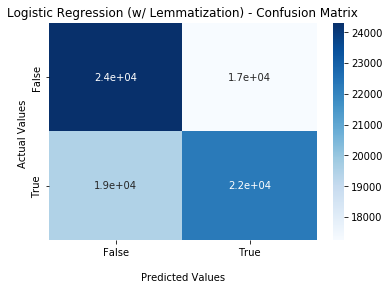

In [217]:
cmatrix_lr_wv=metrics.confusion_matrix(y_test, lr_wv.predict(X_test_wv))

ax = sns.heatmap(cmatrix_lr_wv, annot=True, cmap='Blues')

ax.set_title('Logistic Regression (w/ Lemmatization) - Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.

# 2. Supervised Learning

## Random Classifier

In [218]:
dummy_bow = DummyClassifier(strategy='uniform',random_state=RANDOM_SEED).fit(X_train_transform,y_train)

In [219]:
accuracy_score(y_test, dummy_bow.predict(X_test_transform))

0.5011277203253593

In [220]:
dummy_wv = DummyClassifier(strategy='uniform',random_state=RANDOM_SEED).fit(X_train_wv,y_train)

In [221]:
accuracy_score(y_test,dummy_wv.predict(X_test_wv))

0.5011277203253593

## Logistic Regression Classifier

In [222]:
lr_bow = LogisticRegression(random_state=RANDOM_SEED,max_iter=1000).fit(X_train_transform,y_train)

In [223]:
accuracy_score(y_test,lr_bow.predict(X_test_transform))

0.6433644456174868

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

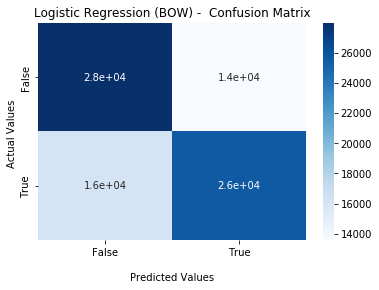

In [224]:
cmatrix_lr_bow=metrics.confusion_matrix(y_test, lr_bow.predict(X_test_transform))

ax = sns.heatmap(cmatrix_lr_bow, annot=True, cmap='Blues')

ax.set_title('Logistic Regression (BOW) -  Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


In [225]:
lr_wv = LogisticRegression(random_state=RANDOM_SEED,max_iter=1000).fit(X_train_wv,y_train)

In [226]:
accuracy_score(y_test,lr_wv.predict(X_test_wv))

0.5593132903040046

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

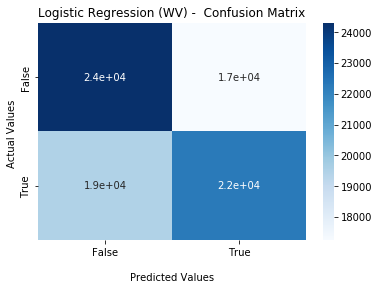

In [227]:
cmatrix_lr_wv=metrics.confusion_matrix(y_test, lr_wv.predict(X_test_wv))

ax = sns.heatmap(cmatrix_lr_wv, annot=True, cmap='Blues')

ax.set_title('Logistic Regression (WV) -  Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## Random Forest Classifier

In [228]:
rf_bow = RandomForestClassifier(n_estimators=500,max_depth=5,random_state=RANDOM_SEED).fit(X_train_transform,y_train)

In [229]:
accuracy_score(y_test,rf_bow.predict(X_test_transform))

0.6357223408594669

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

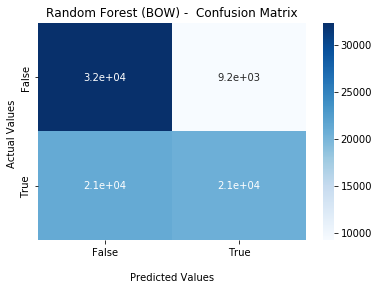

In [230]:
cmatrix_rf_bow=metrics.confusion_matrix(y_test, rf_bow.predict(X_test_transform))

ax = sns.heatmap(cmatrix_rf_bow, annot=True, cmap='Blues')

ax.set_title('Random Forest (BOW) -  Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

In [231]:
rf_wv = RandomForestClassifier(n_estimators=100,max_depth=5,random_state=RANDOM_SEED).fit(X_train_wv,y_train)

In [232]:
accuracy_score(y_test,rf_wv.predict(X_test_wv))

0.59474050435492

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

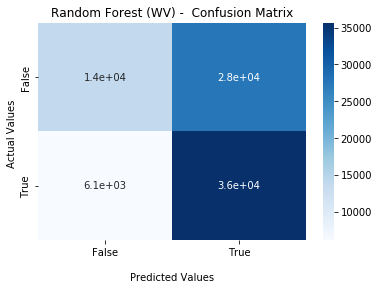

In [233]:
cmatrix_rf_wv=metrics.confusion_matrix(y_test, rf_wv.predict(X_test_wv))

ax = sns.heatmap(cmatrix_rf_wv, annot=True, cmap='Blues')

ax.set_title('Random Forest (WV) -  Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


## XGBoost Classifier

In [234]:
xgb_bow = XGBClassifier(random_state=RANDOM_SEED).fit(X_train_transform,y_train)

In [235]:
accuracy_score(y_test,xgb_bow.predict(X_test_transform))

0.6154593660772129

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

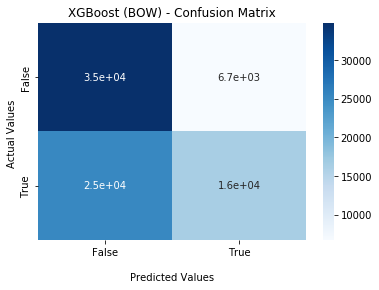

In [236]:
# plot
cmatrix_xgb_bow=metrics.confusion_matrix(y_test, xgb_bow.predict(X_test_transform))

ax = sns.heatmap(cmatrix_xgb_bow, annot=True, cmap='Blues')

ax.set_title('XGBoost (BOW) - Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])



In [237]:
xgb_wv = RandomForestClassifier(random_state=RANDOM_SEED).fit(X_train_wv,y_train)

In [238]:
accuracy_score(y_test,xgb_wv.predict(X_test_wv))

0.6268685366029225

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

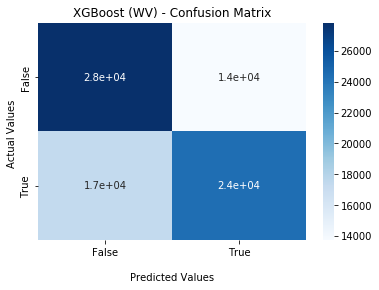

In [239]:
# plot
cmatrix_xgb_wv=metrics.confusion_matrix(y_test, xgb_wv.predict(X_test_wv))

ax = sns.heatmap(cmatrix_xgb_wv, annot=True, cmap='Blues')

ax.set_title('XGBoost (WV) - Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])



# 3. Unsupervised Learning

## NMF

In [43]:
from sklearn.decomposition import NMF

In [44]:
nmf = NMF(n_components=5,random_state=RANDOM_SEED)
W = nmf.fit_transform(X_train_transform)
H = nmf.components_

In [45]:
W_test = nmf.transform(X_test_transform)

In [46]:
words = np.array(vectorizer.get_feature_names())
for i, topic in enumerate(H):
     print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in words[topic.argsort()[-5:]]])))

Topic 1: aisn,commun,region,depart,franc
Topic 2: releas,nation,iowa,state,unit
Topic 3: origin,english,usual,commonli,refer
Topic 4: franc,depart,region,nord,calai
Topic 5: estim,total,area,censu,popul


In [47]:
lr_tm = LogisticRegression(random_state=RANDOM_SEED,max_iter=1000).fit(W,y_train)

In [48]:
accuracy_score(y_test,lr_tm.predict(W_test))

0.5153561916644672

## T-SNE

In [52]:
from sklearn.manifold import TSNE

In [53]:
tsne = TSNE(n_components = 2, init = 'random', random_state = RANDOM_SEED, perplexity = 50)

In [59]:
X_train_wv_embedded= tsne.fit_transform(X_train_wv[164707:168707])

In [60]:
t_df = pd.DataFrame(X_train_wv_embedded,columns=['dimension0','dimension1'])
t_df['label'] = y_train.values[164707:168707]
t_df1=t_df[t_df['label']==1]
t_df0=t_df[t_df['label']==0]

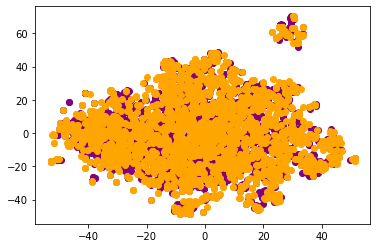

In [64]:
import matplotlib.pyplot as plt
plt.scatter(t_df1['dimension0'],t_df1['dimension1'],color='purple')
plt.scatter(t_df0['dimension0'],t_df0['dimension1'],color='orange');